In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm import tqdm
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import random
from sklearn.preprocessing import StandardScaler

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

c:\Users\axele\.conda\envs\Doris\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
milk_data_OG = pd.read_csv('../Data/TheData.csv')
milk_data_OG['DateTime'] = pd.to_datetime(milk_data_OG['DateTime'], errors='coerce')
milk_data_OG['StartTime'] = pd.to_datetime(milk_data_OG['StartTime'], format='%H:%M:%S', errors='coerce').dt.time
milk_data_OG['StartDate'] = pd.to_datetime(milk_data_OG['StartDate'], errors='coerce')
milk_data = milk_data_OG.copy()
DATA = milk_data[['DateTime', 'StartDate', 'SE_Number','FarmName_Pseudo','TotalYield', 'HW', 'cum_HW', 'DaysInMilk', 'LactationNumber','BreedName', 'Temperature', 'Relative Humidity', 'THI_adj']]


In [9]:
agg_functions = {
    'TotalYield': 'sum', # Daily sum of all the yields. Can be replaced with 'mean' to get daily mean instead
    'HW': 'first', # Since the HW indicator will be the same for all instances of the same day (given the same farm), we save the 'first'
    'cum_HW': 'first', # Same as for 'HW'
    'DaysInMilk': 'first', # Same as for 'HW'
    'LactationNumber': 'first', # Same as for 'HW'
    'BreedName': 'first', # It will be the same cow, so we save first instance of 'BreedName'
    'Temperature': ['mean', 'max', 'min'], #Save both the daily Max temperature as well as daily mean temperature
    'Relative Humidity': 'mean', # Save daily mean humidity
    'THI_adj': 'mean', # save daily mean THI-adjusted
    'FarmName_Pseudo': 'first'

}
daily_data = DATA.groupby(['SE_Number', 'StartDate']).agg(agg_functions).reset_index() #Group by day (StartDate)

# Remove the weird 'first' prefixes from the column names
daily_data.columns = [' '.join(col).strip() if 'first' not in col[1] else col[0] for col in daily_data.columns.values] 

# rename the columns to approiate prefixes
daily_data = daily_data.rename(columns={
    'TotalYield sum': 'DailyTotalYield',
    'DaysInMilk first': 'DaysInMilk',
    'Temperature mean': 'MeanTemperature',
    'Temperature max': 'MaxTemperature',
    'Temperature min' : 'MinTemperature',
    'Relative Humidity mean': 'MeanRelHumidity',
    'THI_adj mean': 'MeanTHI_adj',
    'FarmName_Pseudo first' : 'FarmName_Pseudo'
})


In [10]:

# Define the Wood's Lactation Curve function
def woods_lactation_curve(dim, a, b, c):
    dim = np.array(dim, dtype=float)
    return a * dim**b * np.exp(-c * dim)

# Function to fit the Wood's Lactation Curve to the dataset
def fit_woods_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    
    # Group the dataset by 'SE_Number' and fit the curve for each cow
    for animal_number, group in tqdm(dataset.groupby('SE_Number'), unit= " Cows"):
        # Prepare the data for fitting
        x_data = group['DaysInMilk']
        y_data = group['DailyTotalYield']
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [max(y_data), 0.4, 0.0001]
            # Bounds on the parameters to prevent overflow
            bounds = ([0, 0, 0], [np.inf, 1, 0.1])
            popt, pcov = curve_fit(
                woods_lactation_curve, x_data, y_data,
                p0=initial_guesses, bounds=bounds, maxfev=10000
            )
            
            # Predict the expected yield using the fitted model
            group['ExpectedYield'] = woods_lactation_curve(group['DaysInMilk'], *popt)
            
            # Normalize the DailyTotalYield
            group['NormalizedDailyTotalYield'] = group['DailyTotalYield'] / group['ExpectedYield']
            
            # Update the dataset with the fitted data
            dataset.loc[group.index, 'ExpectedYield'] = group['ExpectedYield']
            dataset.loc[group.index, 'NormalizedDailyTotalYield'] = group['NormalizedDailyTotalYield']
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}: {e}")
    
    # Fill any NaN values in the newly created columns with 0
    dataset['ExpectedYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyTotalYield'].fillna(0, inplace=True)
    
    return dataset

daily_data = fit_woods_lactation_curve(daily_data)
daily_data.head()

  1%|          | 3/376 [00:00<00:15, 24.55 Cows/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 98%|█████████▊| 370/376 [00:22<00:00, 22.58 Cows/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 376/376 [00:22<00:00, 16.90 Cows/s]


,SE_Number,StartDate,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,BreedName,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,FarmName_Pseudo,ExpectedYield,NormalizedDailyTotalYield
0,SE-064c0cec-1189,2022-01-01,30.77,0,0.0,191.0,7,02 SLB,-3.150000,-2.3,-4.0,92.900000,-1587.361000,a624fb9a,29.739372,1.034655
1,SE-064c0cec-1189,2022-01-02,48.22,0,0.0,192.0,7,02 SLB,-0.500000,0.3,-2.1,99.033333,-1428.221600,a624fb9a,29.692059,1.624003
2,SE-064c0cec-1189,2022-01-03,30.53,0,0.0,193.0,7,02 SLB,2.600000,2.9,2.3,97.300000,-1098.689840,a624fb9a,29.644756,1.029862
3,SE-064c0cec-1189,2022-01-04,42.26,0,0.0,194.0,7,02 SLB,-0.466667,-0.1,-1.1,93.300000,-1339.335013,a624fb9a,29.597463,1.427825
4,SE-064c0cec-1189,2022-01-05,38.49,0,0.0,195.0,7,02 SLB,-3.900000,-0.9,-5.9,87.133333,-1533.761680,a624fb9a,29.550181,1.302530


In [11]:
subject_type = 'farm' 
farm_id = 'f454e660' #adjust here for specific farm

data = daily_data[daily_data['FarmName_Pseudo'] == farm_id].copy()

print(f"The daily records dataframe for {farm_id} ({subject_type}) has {data.shape[0]} entries and {data.shape[1]} columns")
data.head()

The daily records dataframe for f454e660 (farm) has 84007 entries and 16 columns


,SE_Number,StartDate,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,BreedName,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,FarmName_Pseudo,ExpectedYield,NormalizedDailyTotalYield
1571,SE-7fd04cd3-679,2022-01-01,12.93,0,0.0,339.0,4,04 SJB,1.2,1.2,1.2,81.700000,-1031.670280,f454e660,13.574447,0.952525
1572,SE-7fd04cd3-679,2022-01-02,13.72,0,0.0,340.0,4,04 SJB,4.9,4.9,4.9,99.000000,-892.587600,f454e660,13.614490,1.007750
1573,SE-7fd04cd3-679,2022-01-03,14.19,0,0.0,341.0,4,04 SJB,4.7,4.7,4.7,94.800000,-874.350960,f454e660,13.654533,1.039215
1574,SE-a2bab923-0680,2022-01-01,36.88,0,0.0,70.0,8,04 SJB,2.2,5.1,0.3,87.866667,-1016.724893,f454e660,29.875932,1.234438
1575,SE-a2bab923-0680,2022-01-02,19.70,0,0.0,71.0,8,04 SJB,5.3,5.7,4.9,99.050000,-851.137800,f454e660,29.853454,0.659890


### Apply standardization to other features, then apply [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), [UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

In [78]:
cow_counts = data['SE_Number'].value_counts()
top_cows = cow_counts.head(10).index.tolist() # top 10 cows
seed = 101
random.seed(seed)
selected_se_numbers = random.sample(top_cows, 9) # sample 9 from here top 10

subset_data = data[data['SE_Number'].isin(selected_se_numbers)]
subset_data = subset_data.dropna()

# Separate features for PCA 
features1 = subset_data[['DaysInMilk',
                        'LactationNumber',
                        'MeanTemperature',
                        'MeanTHI_adj']] # Features to be standardized 

features1.reset_index(drop=True, inplace=True)

# features2 = subset_data[['HW','cum_HW']]
# features2.reset_index(drop=True, inplace=True)

scaler = StandardScaler()
normalized_features = pd.DataFrame(scaler.fit_transform(features1), columns=features1.columns) 

normalized_yield = subset_data['NormalizedDailyTotalYield']
normalized_yield.reset_index(drop=True, inplace=True)

#all_features = pd.concat([normalized_features, features2, normalized_yield], axis=1)
all_features = pd.concat([normalized_features, normalized_yield], axis=1)

#min_yield, max_yield = normalized_yield.min(), normalized_yield.max()
#normalized_yield = ((normalized_yield - min_yield) / (max_yield - min_yield))**3

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['SE_Number'] = subset_data['SE_Number'].reset_index(drop=True)
pca_df['NormalizedDailyTotalYield'] = normalized_yield.reset_index(drop=True)

# t-SNE
tsne = TSNE(n_components=2, random_state=seed)
tsne_result = tsne.fit_transform(all_features)
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['SE_Number'] = subset_data['SE_Number'].reset_index(drop=True)
tsne_df['NormalizedDailyTotalYield'] = normalized_yield.reset_index(drop=True)

# UMAP
umap_model = UMAP(n_components=2, random_state=seed)
umap_result = umap_model.fit_transform(all_features)
umap_df = pd.DataFrame(data=umap_result, columns=['Dim1', 'Dim2'])
umap_df['SE_Number'] = subset_data['SE_Number'].reset_index(drop=True)
umap_df['NormalizedDailyTotalYield'] = normalized_yield.reset_index(drop=True)


c:\Users\axele\.conda\envs\Doris\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


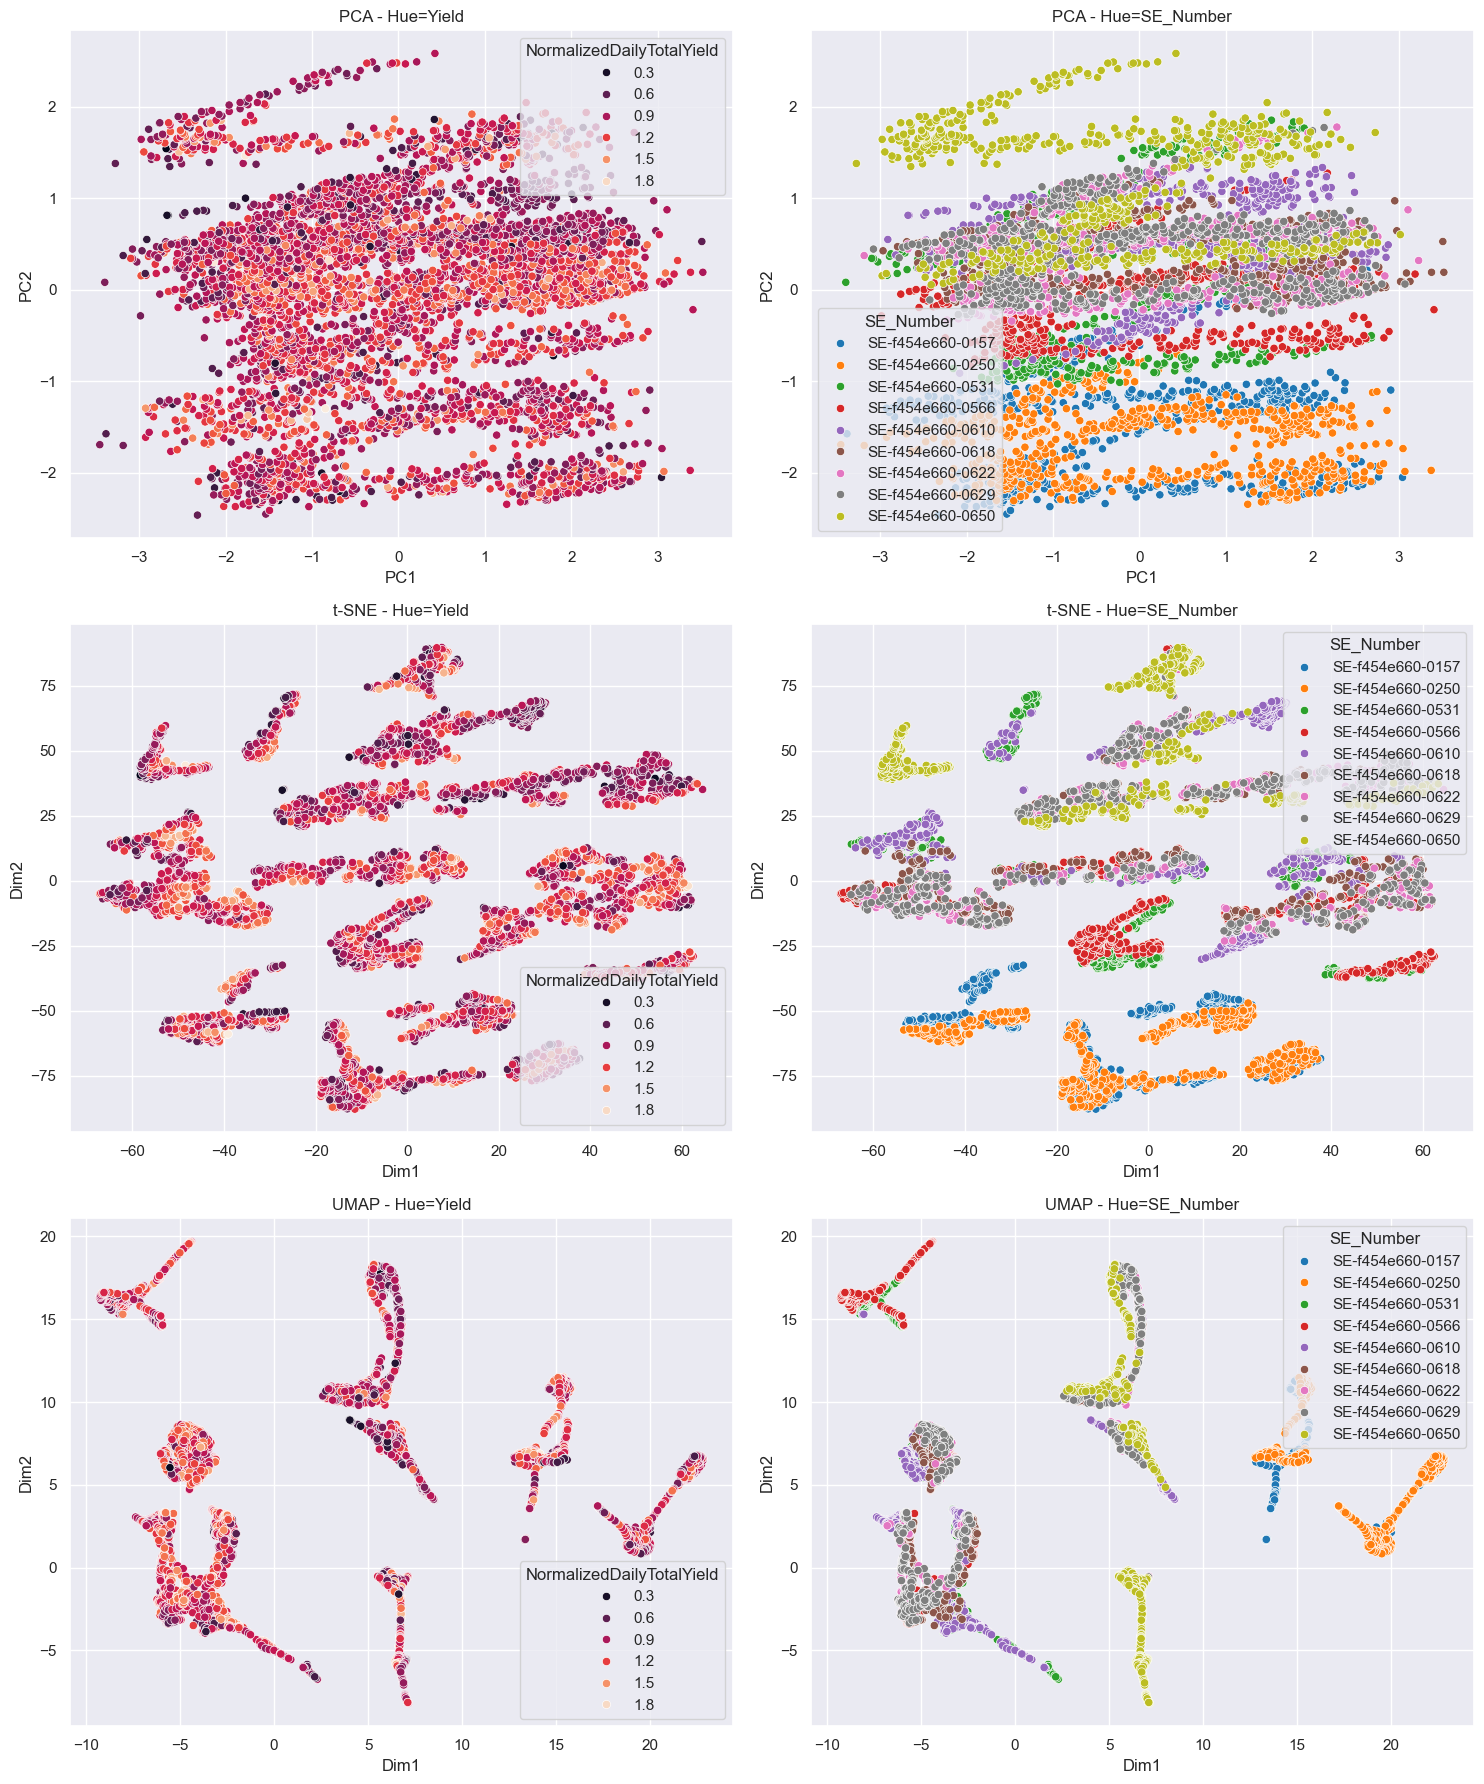

In [80]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot PCA
sns.scatterplot(x='PC1', y='PC2', hue='NormalizedDailyTotalYield', data=pca_df, palette='rocket', ax=axes[0, 0])
axes[0, 0].set_title('PCA - Hue=Yield')

sns.scatterplot(x='PC1', y='PC2', hue='SE_Number', data=pca_df, palette='tab10', ax=axes[0, 1])
axes[0, 1].set_title('PCA - Hue=SE_Number')

# Plot t-SNE
sns.scatterplot(x='Dim1', y='Dim2', hue='NormalizedDailyTotalYield', data=tsne_df, palette='rocket', ax=axes[1, 0])
axes[1, 0].set_title('t-SNE - Hue=Yield')

sns.scatterplot(x='Dim1', y='Dim2', hue='SE_Number', data=tsne_df, palette='tab10', ax=axes[1, 1])
axes[1, 1].set_title('t-SNE - Hue=SE_Number')

# PLot UMAP
sns.scatterplot(x='Dim1', y='Dim2', hue='NormalizedDailyTotalYield', data=umap_df, palette='rocket', ax=axes[2, 0])
axes[2, 0].set_title('UMAP - Hue=Yield')

sns.scatterplot(x='Dim1', y='Dim2', hue='SE_Number', data=umap_df, palette='tab10', ax=axes[2, 1])
axes[2, 1].set_title('UMAP - Hue=SE_Number')

plt.tight_layout()
plt.show()